# Several utilities

## Load libraries

In [1]:
#Autoreload .py files
%load_ext autoreload
%autoreload 2

#https://github.com/chmp/ipytest/issues/80
import sys
sys.breakpointhook = sys.__breakpointhook__

In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_columns= 100
import os, sys, yaml
from pathlib import Path
from pprint import pprint
from datetime import datetime
from lovely_numpy import lo
import xarray as xr
from collections import defaultdict
from tqdm.auto import tqdm
from lib.aggregateevents import aggregate_events
import cartopy.crs as ccrs
from IPython.display import Image, display 
import matplotlib.patches as patches
import cartopy.feature as cfeature
import cartopy


from lovely_numpy import lo
import lovely_tensors as lt
lt.monkey_patch()

#Reset matplotlib config and change defaults
import matplotlib.pyplot as plt, matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)    
plt.style.use('ggplot')
mpl.rcParams.update({'font.size': 10})

#Data loder
from lib.data_loader import DeepExtremes

## Load configuration file and set up data loader

In [5]:
#Set up the paths
experiment_id= '2024_04_base'
experiment_path= f'/home/oscar/DeepExtremesXAI/experiments/{experiment_id}/lightning_logs/version_0/hparams.yaml'

#Load used config
config= yaml.load(open(experiment_path,'rt'), Loader=yaml.FullLoader)['config']
config['experiment_id']= experiment_id
config['experiment_path']= experiment_path
config['data']['datacubes_path']= str(Path('/scratch/users/databases/deepextremes/'))
config['data']['registry_path']= str(
    Path('/scratch/users/databases/deepextremes/deepextremes-minicubes/registry_2023_11_03_11_20_21.csv').expanduser().resolve())
config['data']['blacklist_path']= str(Path('./subsets/bad_cubes_final.txt').resolve())
config['data']['testlist_csv']= str(Path('./subsets/demc_full_10groups_50km.csv'))

## Plot all events in a map

/home/oscar/DeepExtremesXAI/lib/data_loader.py:38: DtypeWarning: Columns (4,23) have mixed types. Specify dtype option on import or set low_memory=False.
  self.registry= pd.read_csv(registry_path)


 > Using fold 5 from test list /scratch/users/deepextremes/demc_full_10groups_50km.csv with 3696 items
Using blacklist_file=Path('/home/oscar/DeepExtremesXAI/subsets/bad_cubes_final.txt') with 434 items
Found 3678 minicubes with subset='test', versions=None, self.test_start_date=datetime.datetime(2021, 10, 8, 0, 0), self.ignore_first_N=146 from /scratch/users/deepextremes
Could not load high resolution background image: Expecting property name enclosed in double quotes: line 28 column 3 (char 1316)


/home/oscar/DeepExtremesXAI/lib/data_loader.py:38: DtypeWarning: Columns (4,23) have mixed types. Specify dtype option on import or set low_memory=False.
  self.registry= pd.read_csv(registry_path)


Found 3678 minicubes with subset='test', versions=None, self.test_start_date=datetime.datetime(2021, 10, 8, 0, 0), self.ignore_first_N=146 from /scratch/users/deepextremes


test:   0%|          | 0/3678 [00:00<?, ?it/s]

/home/oscar/DeepExtremesXAI/lib/data_loader.py:38: DtypeWarning: Columns (4,23) have mixed types. Specify dtype option on import or set low_memory=False.
  self.registry= pd.read_csv(registry_path)


Found 27379 minicubes with subset='train', versions=None, self.test_start_date=datetime.datetime(2021, 10, 8, 0, 0), self.ignore_first_N=146 from /scratch/users/deepextremes


train:   0%|          | 0/27379 [00:00<?, ?it/s]

/home/oscar/DeepExtremesXAI/lib/data_loader.py:38: DtypeWarning: Columns (4,23) have mixed types. Specify dtype option on import or set low_memory=False.
  self.registry= pd.read_csv(registry_path)


Found 3644 minicubes with subset='val', versions=None, self.test_start_date=datetime.datetime(2021, 10, 8, 0, 0), self.ignore_first_N=146 from /scratch/users/deepextremes


val:   0%|          | 0/3644 [00:00<?, ?it/s]

recent_events_path=Path('subsets/RecentEvents.csv') does not exist (not plotting recent events)


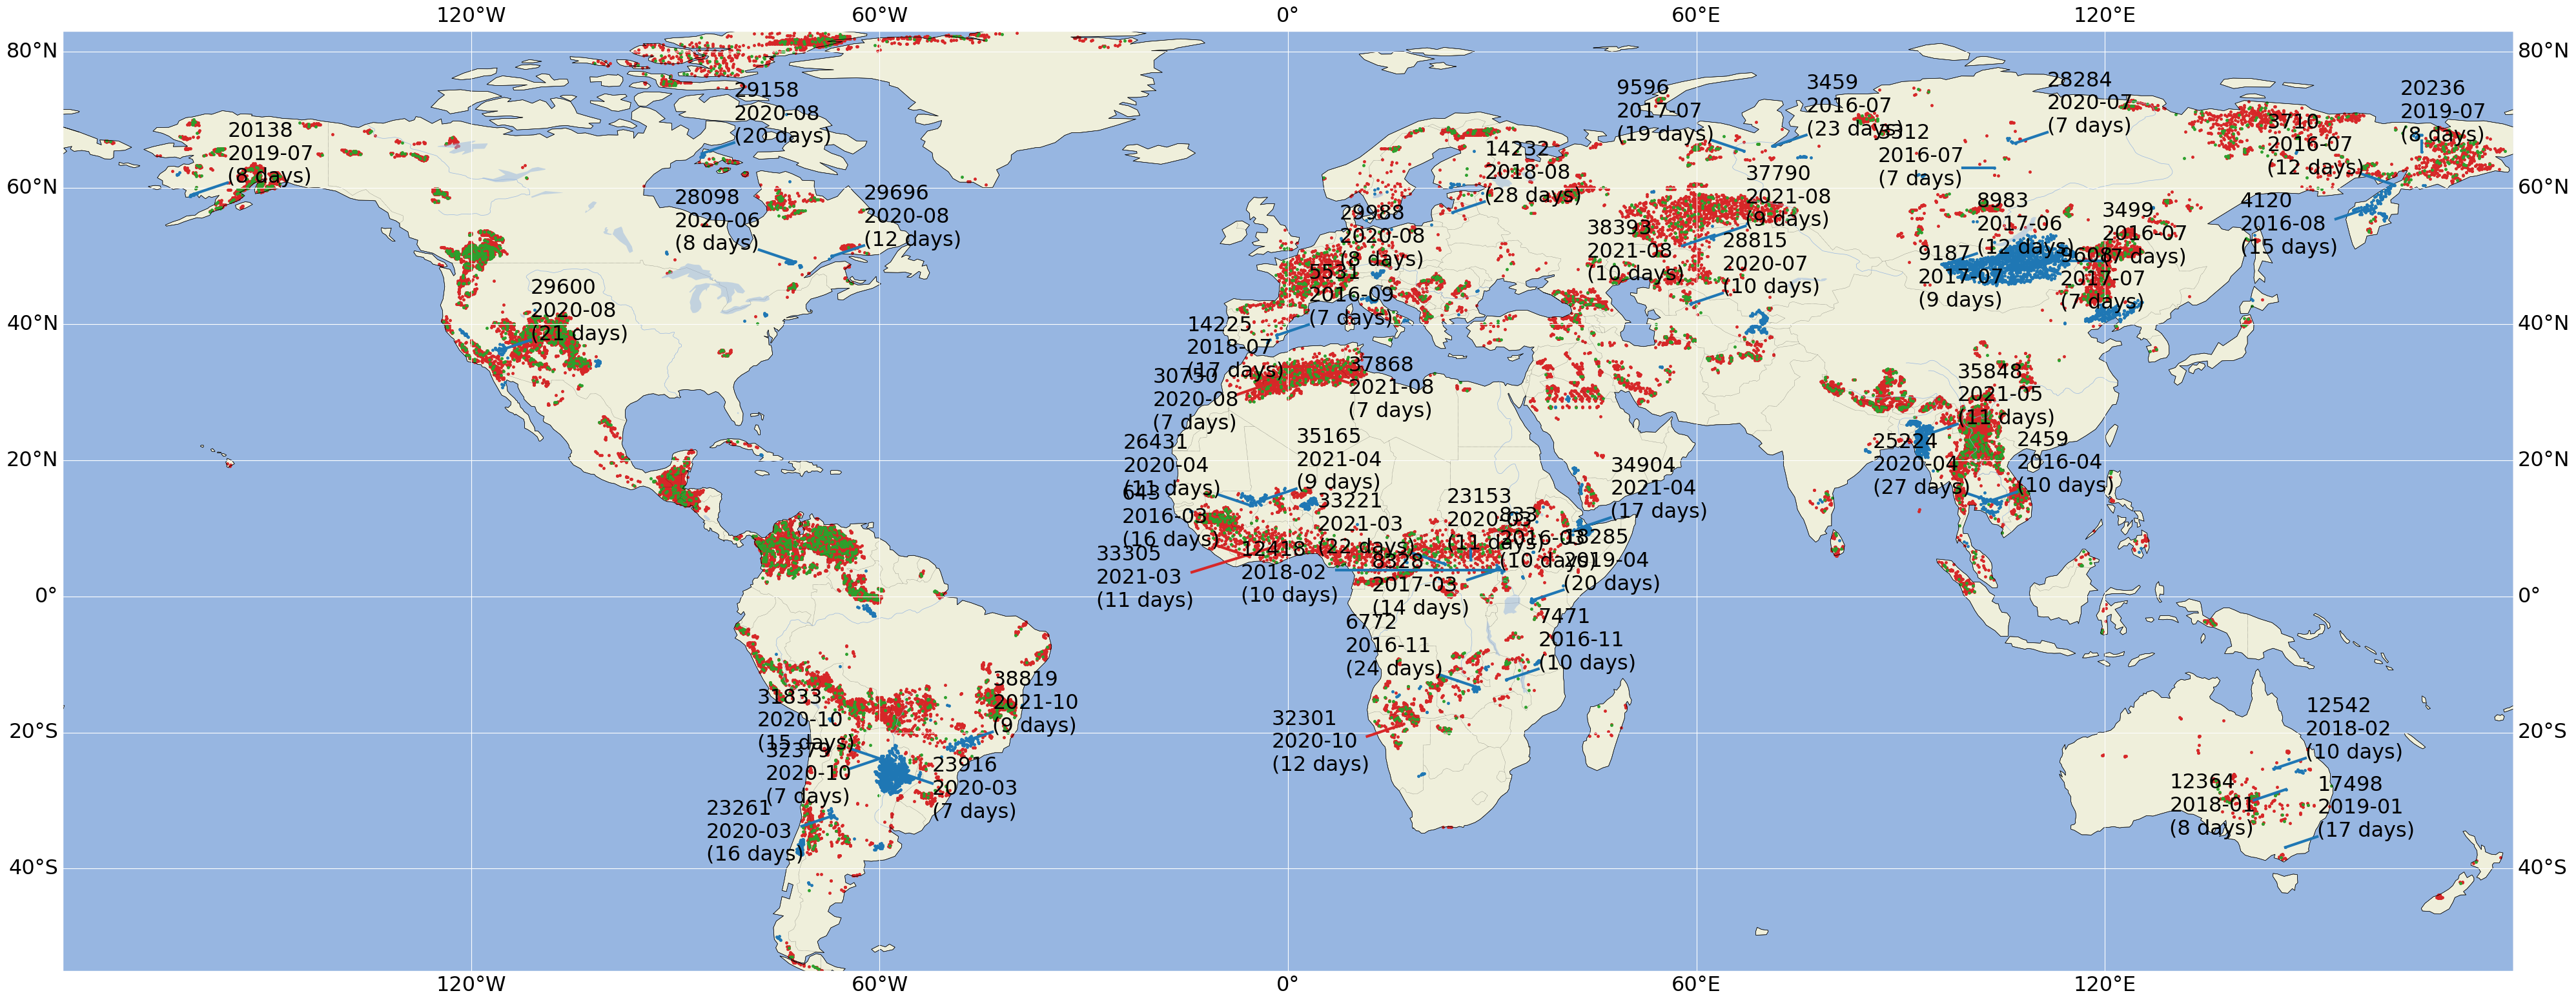

In [40]:
# assert False, 'Comment out this line to run this cell'

FONT_SIZE= 23
min_duration= 10 #Minimum event duration (in days) to plot it in the map
sample_perc= 1. #If < 1, sample a % of cubes for the generation of the map
registry_test= DeepExtremes(config, debug=True, subset='test').registry

#Get long test events
plot_events= []
for e_cube in registry_test['events']:
    for e in e_cube:
        start, end=  datetime.strptime(e[2], '%Y-%m-%d'), datetime.strptime(e[1], '%Y-%m-%d')
        duration= start-end
        if duration.days >= min_duration and (e[0], duration, start) not in plot_events: 
            plot_events.append((e[0], duration, start))

# Define the map projection and plot the map
fig = plt.figure(figsize=(40, 50))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add coastlines with a higher resolution
ax.add_feature(cfeature.COASTLINE.with_scale('110m'))
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.3)
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
# ax.coastlines()

# Add high-resolution imagery as background. Not working
try:
    os.environ['CARTOPY_USER_BACKGROUNDS']= '/home/oscar/cartopy_images'
    ax.background_img(name='ETOPO', resolution='high')
except Exception as e:
    print(f'Could not load high resolution background image: {e}')
    # ax.stock_img()

# Add gridlines with labels
gl= ax.gridlines(draw_labels=True)
gl.xlabel_style = {'size': FONT_SIZE}
gl.ylabel_style = {'size': FONT_SIZE}

text_x, text_y, text_content, text_color= [], [], [], []
for color, name in zip(['tab:blue', 'tab:red', 'tab:green'], ['test', 'train', 'val']):
    #Get registry df
    registry= DeepExtremes(config, debug=False, subset=name).registry
    if sample_perc < 1: registry= registry.iloc[:int(sample_perc*len(registry))]

    # Plot the transformed bounding box on the map
    min_x, max_x, min_y, max_y= 1000, -1000, 1000, -1000
    for i, (x1, y1, x2, y2, data_id, events, loc_id) in enumerate(tqdm(zip(registry.geometry_x1, registry.geometry_y1, 
            registry.geometry_x2, registry.geometry_y2, registry.index.values, registry.events, registry.index), 
               total=len(registry), desc=name)):        
        #Get event labels for the cube
        minicube= xr.open_dataset(Path(config['data']['datacubes_path']) / registry.loc[loc_id].path, engine='zarr')
        event_labels= np.unique((minicube[['event_labels']].to_array().values.squeeze()))[1:]

        #Compute limits for later focusing only on the imporatant area
        min_x, max_x, min_y, max_y= min(min_x, x1), max(max_x, x1), min(min_y, y1), max(max_y, y1),
        avg_x, avg_y= (x1 + x2)/2, (y1 + y2)/2

        #Plot 
        a1= ax.plot(avg_x, avg_y, '.', markersize=5, color=color, label=name if not i else None, 
                    zorder=10 if name=='test' else 1)
        for event, duration, start in plot_events:
            if event in event_labels:
                #print(name, event)
                text_x.append(avg_x); text_y.append(avg_y); text_color.append(color)
                text_content.append(f'{event}\n{start.strftime("%Y-%m")}\n({duration.days} days)')
                plot_events= [e for e in plot_events if e[0] != event] #Delete event from plot_events
                break
                
#Print non-overlaping text if textalloc is intalled
try:
    import textalloc as ta
    ta.allocate_text(fig, ax, text_x, text_y, text_content, #[t.replace('\n', ' ') for t in text_content], 
                     x_scatter=text_x, y_scatter=text_y, textsize=FONT_SIZE, zorder=11, linecolor=text_color,
                     src_crs=ccrs.TransverseMercator(), avoid_label_lines_overlap=True, max_distance=0.1,
                     linewidth=3)
except Exception as e:
    print(f'Could not print text using textalloc, please pip install it to avoid overlaping text: {e}')
    for x, y, text in zip(text_x, text_y, text_content):
        ax.text(x, y, text, va='center', ha='center', fontsize=FONT_SIZE, zorder=11)
                
#Plot bounding boxes of recent events if available
recent_events_path= Path('./subsets/RecentEvents.csv')
if recent_events_path.exists() and False: #Do not print!
    events_df= pd.read_csv(recent_events_path)
    events_df.index= events_df.index + 1 #Set correct index for matching with Sanity check
    events_df= events_df[events_df.index.isin(event_ids_df.obs_event.unique())] #Remove events for which we have no cubes
    events_df.loc[:, 'Start']= events_df.loc[:, 'Start'].apply(lambda s: datetime.strptime(s, '%Y-%m-%d'))
    events_df.loc[:, 'End']= events_df.loc[:, 'End'].apply(lambda s: datetime.strptime(s, '%Y-%m-%d'))
    events_df= events_df[events_df['Start'] >  datetime.strptime('2019', '%Y')] #Events must be at least from 2019
    display(events_df)
    
    for ib, (x1b, y1b, x2b, y2b, event, start, end) in enumerate(zip(events_df.West, events_df.South, 
        events_df.East, events_df.North, events_df.Area, events_df.Start, events_df.End)):
        width, height = x2b - x1b, y2b - y1b
        ax.add_patch(patches.Rectangle((x1b, y1b), width, height, linewidth=1,  edgecolor='r', facecolor='none'))
        ax.text((x1b + x2b)/2, (y1b + y2b)/2, f'[{ib}] {start.strftime("%Y-%m")}\n{event}', va='center', 
                ha='center', fontsize='x-large', zorder=12) #Plot event ID
else:
    print(f'{recent_events_path=} does not exist (not plotting recent events)')
                
# Set the extent of the map to the bounding box
eps= 0.3
ax.set_extent([min_x-eps, max_x+eps, min_y-eps, max_y+eps])
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(FONT_SIZE)
fig.tight_layout()
# plt.legend()
# plt.setp(plt.gca().get_legend().get_texts(), fontsize=FONT_SIZE)
fig.savefig(Path('./') / f'map2.png', dpi=150, bbox_inches='tight')
plt.show()

## Detect and write out lists of problematic cubes

Warning: original .txt files will be overwriten

In [6]:
assert False, 'Comment out this line to run this cell'

cubes_nan_era5, cubes_unreadable, cubes_nan_s2, cubes_nan_mask=[],[],[],[]
DE= DeepExtremes(config, debug=False, subset='all')
for cid in tqdm(DE.registry.index):
    row= DE.get_row(cid)
    cube_path= row.path
    try:
        minicube= xr.open_dataset(DE.datacubes_path / cube_path, engine='zarr')
    except:
        cubes_unreadable.append(cube_path)
        continue
    t_real= minicube[DE.t_real].to_array().values
    if np.all(np.isnan(t_real)): cubes_nan_era5.append(cube_path)
    
    txy_real= minicube[DE.txy_real].to_array("band").values
    if np.all(np.isnan(txy_real)): cubes_nan_s2.append(cube_path)
    
    try:
        txy_mask= minicube[DE.txy_mask].to_array().values
    except Exception as e:
        cubes_nan_mask.append(cube_path)
    continue
    
if len(cubes_nan_era5):
    with open('cubes_no_era5.txt', 'a') as f:
        for c in cubes_nan_era5:
            f.write(f'{c}\n')
            
if len(cubes_unreadable):
    with open('cubes_unreadable.txt', 'a') as f:
        for c in cubes_unreadable:
            f.write(f'{c}\n')

if len(cubes_nan_s2):
    with open('cubes_no_s2.txt', 'a') as f:
        for c in cubes_nan_s2:
            f.write(f'{c}\n')
            
if len(cubes_nan_mask):
    with open('cubes_nan_mask.txt', 'a') as f:
        for c in cubes_nan_mask:
            f.write(f'{c}\n')

AssertionError: Comment out this line to run this cell